In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\admin\anaconda3\envs\Deeplearnn\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# Set directories
base_dir = "input"
train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Testing')
test_dir = os.path.join(base_dir, 'Testing')

In [3]:
# Set parameters
epochs = 25  # Increase the number of epochs
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [4]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Data generators
train_data_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

val_data_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

test_data_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 5740 images belonging to 4 classes.
Found 374 images belonging to 4 classes.
Found 374 images belonging to 4 classes.


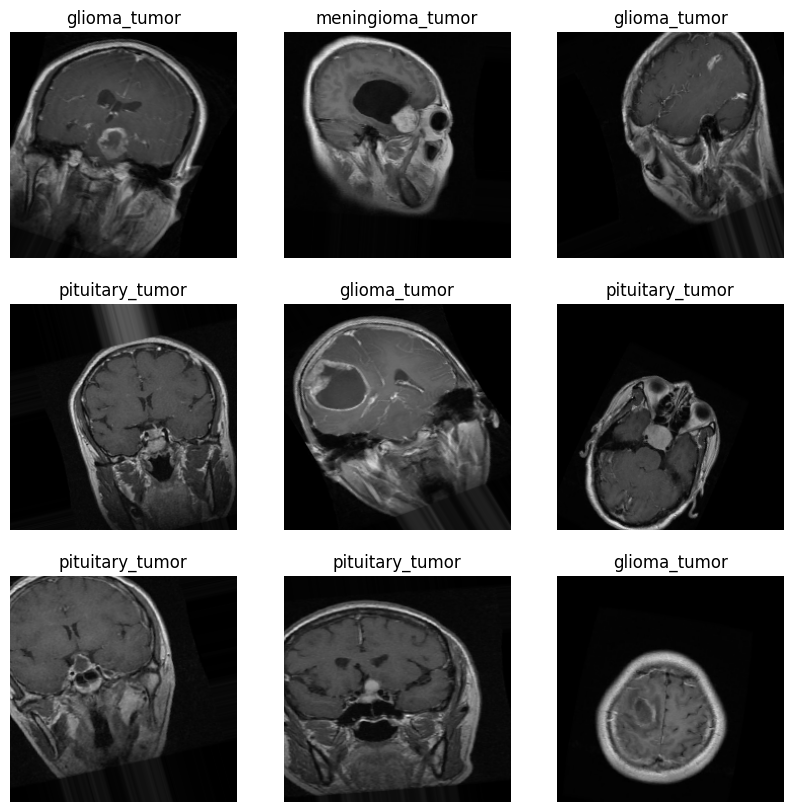

In [6]:
image_batch, label_batch = next(iter(train_data_generator))
import matplotlib.pyplot as plt
class_names=list(train_data_generator.class_indices.keys())
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  label = label_batch[i].tolist().index(max(label_batch[i].tolist()))
  plt.title(class_names[label])
  plt.axis("off")

In [7]:
for image_batch, label_match in train_data_generator:
    break
image_batch.shape, label_match.shape

((32, 224, 224, 3), (32, 4))

In [8]:
labels = train_data_generator.class_indices
print(labels)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [9]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Create a new model on top of VGG16
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])


In [13]:
# Implement fine-tuning
for layer in model.layers[-6:]:
    layer.trainable = True

In [14]:
# Implement a learning rate schedule
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)

In [15]:
# Compile the model with the new learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
#check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 21,138,500
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Train the model with fine-tuning
history_fine_tune = model.fit_generator(train_data_generator,
                                        epochs=epochs,
                                        validation_data=val_data_generator)


C:\Users\admin\AppData\Local\Temp\ipykernel_8968\359221394.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_fine_tune = model.fit_generator(train_data_generator,


Epoch 1/25
180/180 [==============================] - 1474s 8s/step - loss: 1.1274 - accuracy: 0.4908 - val_loss: 1.2423 - val_accuracy: 0.4706
Epoch 2/25
180/180 [==============================] - 1470s 8s/step - loss: 0.6568 - accuracy: 0.7523 - val_loss: 0.7174 - val_accuracy: 0.7567
Epoch 3/25
180/180 [==============================] - 1467s 8s/step - loss: 0.5580 - accuracy: 0.7911 - val_loss: 0.8105 - val_accuracy: 0.7594
Epoch 4/25
180/180 [==============================] - 1463s 8s/step - loss: 0.3757 - accuracy: 0.8707 - val_loss: 0.7358 - val_accuracy: 0.7941
Epoch 5/25
180/180 [==============================] - 1464s 8s/step - loss: 0.2378 - accuracy: 0.9204 - val_loss: 0.5456 - val_accuracy: 0.8476
Epoch 6/25
180/180 [==============================] - 1464s 8s/step - loss: 0.2184 - accuracy: 0.9268 - val_loss: 0.5498 - val_accuracy: 0.8770
Epoch 7/25
180/180 [==============================] - 1463s 8s/step - loss: 0.2121 - accuracy: 0.9284 - val_loss: 0.3757 - val_accuracy:

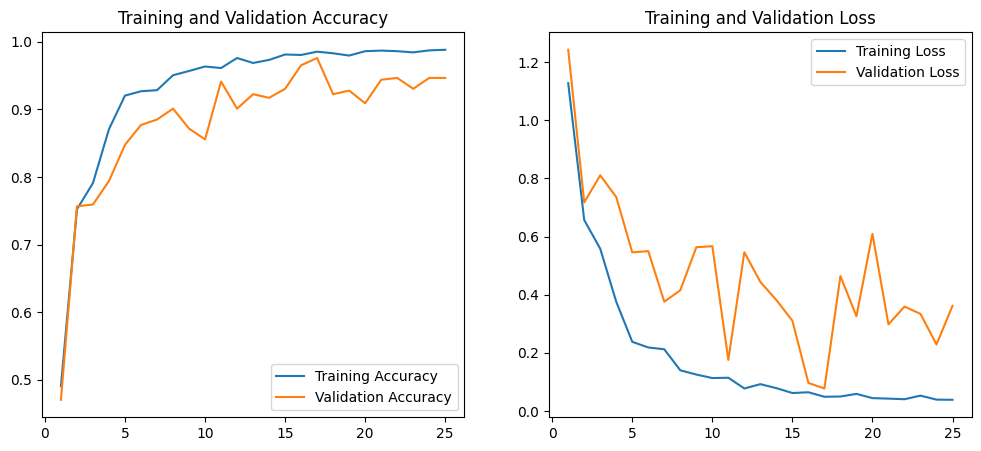

In [18]:
# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
    
# Plot the training history
plot_training_history(history_fine_tune)

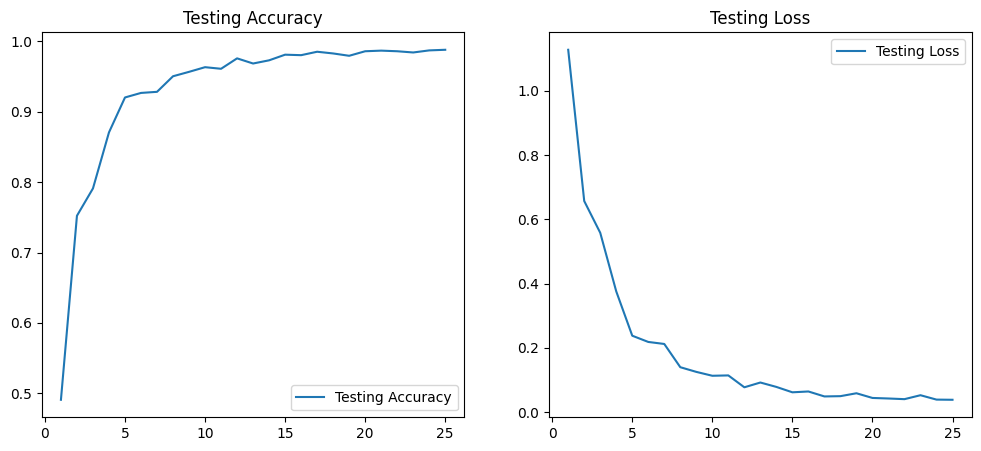

In [19]:
# Plot testing history
def plot_testing_history(history):
    test_acc = history.history['accuracy']
    test_loss = history.history['loss']

    epochs_range = range(1, len(test_acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, test_acc, label='Testing Accuracy')
    plt.legend(loc='lower right')
    plt.title('Testing Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, test_loss, label='Testing Loss')
    plt.legend(loc='upper right')
    plt.title('Testing Loss')

    plt.show()

# Plot the testing history
plot_testing_history(history_fine_tune)

In [20]:
# Evaluate on test data
test_loss, test_acc = model.evaluate_generator(test_data_generator)
print('Test accuracy after fine-tuning:', test_acc)

C:\Users\admin\AppData\Local\Temp\ipykernel_8968\3513301751.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_data_generator)


Test accuracy after fine-tuning: 0.9465240836143494


In [21]:
# Save the model
model.save("vgg16_brain_tumor_model.h5")